In [1]:
# importing libraries
import os, time, random, sys
os.environ['PYTHONHASHSEED']=str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
#plt.style.use('seaborn-deep')
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.utils as sku
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow import keras as k

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [3]:
seed = 12
def runSeed():
    global seed
    # Set Python's hash seed for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Set TensorFlow's random seed
    tf.random.set_seed(seed)
    
    # Set NumPy's random seed
    np.random.seed(seed)
    
    # Set Python's built-in random seed
    random.seed(seed)

# Call the function to set seeds
runSeed()

In [4]:
def showImage(img):
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.show()

In [8]:
import pandas as pd
import zipfile

basePath = 'archive.zip'  # path to your zip file

with zipfile.ZipFile(basePath, 'r') as archive:
    # List files inside zip (optional)
    print(archive.namelist())
    
    # Read the CSV file from inside the zip
    with archive.open('labels/labels.csv') as file:
        labels_df = pd.read_csv(file)

print(labels_df.head())

['images/20160928-140314-0.jpg', 'images/20160928-140337-0.jpg', 'images/20160928-140731-0.jpg', 'images/20160928-140747-0.jpg', 'images/20160928-141107-0.jpg', 'images/20160928-141135-0.jpg', 'images/20160928-141355-0.jpg', 'images/20160928-141421-0.jpg', 'images/20160928-141437-0.jpg', 'images/20160928-142056-0.jpg', 'images/20160928-142103-0.jpg', 'images/20160928-142110-0.jpg', 'images/20161207-110730-0.jpg', 'images/20161207-110753-0.jpg', 'images/20161207-110822-0.jpg', 'images/20161207-110837-0.jpg', 'images/20161207-110850-0.jpg', 'images/20161207-110901-0.jpg', 'images/20161207-110913-0.jpg', 'images/20161207-111001-0.jpg', 'images/20161207-111013-0.jpg', 'images/20161207-111058-0.jpg', 'images/20161207-111112-0.jpg', 'images/20161207-111122-0.jpg', 'images/20161207-111134-0.jpg', 'images/20161207-111143-0.jpg', 'images/20161207-111159-0.jpg', 'images/20161207-111232-0.jpg', 'images/20161207-111246-0.jpg', 'images/20161207-111317-0.jpg', 'images/20161207-111327-0.jpg', 'images

## 1. Data Preparation

In [9]:
# constants
batch_size = 32
img_dim = 224 #changeForAnotherModel
epoch=10
def getImgTensor(img_d):
    return (img_d, img_d, 3)
getImgTensor(img_dim)

(224, 224, 3)

In [10]:
# Step 1: Shuffle the DataFrame
shuffled_df = labels_df.sample(frac=1, random_state=seed)

# Step 2: Split into train, val, and test
train_size = 0.70
val_size = 0.2
test_size = 0.1

# Calculate split indices
train_end = int(train_size * len(shuffled_df))
val_end = train_end + int(val_size * len(shuffled_df))

# Split the DataFrame
df_train = shuffled_df[:train_end]
df_val = shuffled_df[train_end:val_end]
df_test = shuffled_df[val_end:]

# Step 3: Reset the index for each split
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Step 4: Convert 'Label' column to string (if needed)
df_train['Label'] = df_train['Label'].astype('str')
df_val['Label'] = df_val['Label'].astype('str')
df_test['Label'] = df_test['Label'].astype('str')

# Print the sizes of the splits to verify
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")

Training set size: 12256
Validation set size: 3501
Test set size: 1752


Label counts:
Label
8    9106
0    1125
6    1074
1    1064
4    1062
2    1031
3    1022
7    1016
5    1009
Name: count, dtype: int64


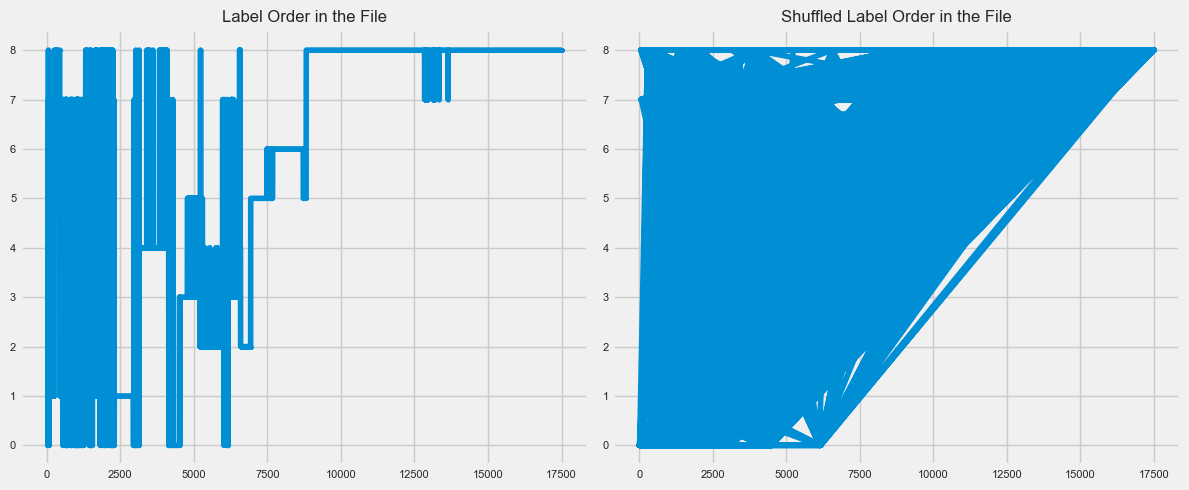

In [11]:
# Check the distribution of labels
label_counts = labels_df['Label'].value_counts()
print("Label counts:")
print(label_counts)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original label order
axes[0].plot(labels_df['Label'], marker='o', linestyle='-', markersize=2)
axes[0].set_title('Label Order in the File')
axes[0].grid(True)

# Shuffled label order
axes[1].plot(shuffled_df['Label'], marker='o', linestyle='-', markersize=2)
axes[1].set_title('Shuffled Label Order in the File')
axes[1].grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [12]:
df_train.head()


,Filename,Label,Species
0,20171102-122425-1.jpg,2,Parkinsonia
1,20171109-092312-1.jpg,5,Rubber vine
2,20170728-153128-1.jpg,4,Prickly acacia
3,20171109-093358-1.jpg,5,Rubber vine
4,20170630-152316-0.jpg,0,Chinee apple


In [13]:
# Image Data Generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,#changeForAnotherModel
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # vertical_flip=True,
    # brightness_range=[0.8, 1.2],
    # fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input#changeForAnotherModel
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input#changeForAnotherModel
)

In [23]:
import zipfile
import os

basePath = 'archive.zip'
extract_dir = 'extracted_data'  # folder where you'll extract

# Extract everything or specific folders inside the zip
with zipfile.ZipFile(basePath, 'r') as archive:
    archive.extractall(extract_dir)

imgPath = os.path.join(extract_dir, 'images')  # e.g., extracted_data/images
labelsPath = os.path.join(extract_dir, 'labels', 'labels.csv')  # extracted_data/labels/labels.csv


In [24]:
# Train Generator
train_generator = train_datagen.flow_from_dataframe(
    directory=extract_dir + '/images/',
    dataframe=df_train,
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    color_mode="rgb",
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=(img_dim, img_dim)
)

Found 12256 validated image filenames belonging to 9 classes.


In [25]:
# Validation Generator
val_generator = val_datagen.flow_from_dataframe(
    directory=imgPath,
    dataframe=df_val,
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    color_mode="rgb",
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=getImgTensor(img_dim)[:2]
)

# Test Generator
test_generator = test_datagen.flow_from_dataframe(
    directory=imgPath,
    dataframe=df_test,
    x_col='Filename',
    y_col='Label',
    batch_size=batch_size,
    color_mode="rgb",
    seed=seed,
    shuffle=False,
    class_mode="categorical",
    target_size=getImgTensor(img_dim)[:2]
)

Found 3501 validated image filenames belonging to 9 classes.
Found 1752 validated image filenames belonging to 9 classes.


In [26]:
# Compute class weights with balanced data
class_weights = sku.class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
train_class_weights = {i: x for i, x in enumerate(class_weights)}
print("class weights:", train_class_weights)

class weights: {0: 1.798913841185968, 1: 1.8861188057863958, 2: 1.8861188057863958, 3: 1.8992716565938323, 4: 1.7526097526097526, 5: 1.9850988014253321, 6: 1.7708423638202573, 7: 1.9565772669220944, 8: 0.21244583116658}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-92.002846..151.061].


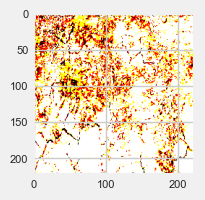

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Batch Size 32


In [27]:
# Get a batch of data
images, labels = next(train_generator)
#Show image
showImage(images[0])
# Print the labels
print(labels)
print("Batch Size",len(labels))

In [28]:
total_samples = train_generator.n
print(f"Total number of samples: {total_samples}")
class_counts = df_train['Label'].value_counts()
print("Number of samples per class:")
print(class_counts)

Total number of samples: 12256
Number of samples per class:
Label
8    6410
4     777
6     769
0     757
2     722
1     722
3     717
7     696
5     686
Name: count, dtype: int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.11403..151.05917].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.54678..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.13491..150.6929].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.03204].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-115.23264..150.89001].


Batch size: 32


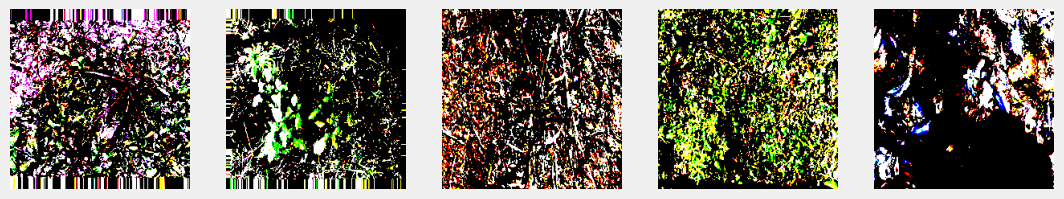

In [29]:
import matplotlib.pyplot as plt

# Get one batch
batch_images, batch_labels = next(train_generator)
print(f"Batch size: {batch_images.shape[0]}")

# Plot a few images from the batch
for i in range(min(5, batch_size)):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch_images[i])
    plt.axis('off')
plt.show()

## 2. Model Building

In [30]:
def squeeze_excite_block(input_tensor, ratio=16):
    # Get the number of channels (filters) in the input tensor
    channels = input_tensor.shape[-1]
    
    # Squeeze: Global Average Pooling across spatial dimensions
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    
    # Excite: Two dense layers to learn channel-wise weights
    excitation = tf.keras.layers.Dense(channels // ratio, activation='relu')(squeeze)
    excitation = tf.keras.layers.Dense(channels, activation='sigmoid')(excitation)
    
    # Reshape excitation to match the input tensor's shape for multiplication
    excitation = tf.keras.layers.Reshape((1, 1, channels))(excitation)
    
    # Scale: Multiply the input tensor by the excitation weights
    scaled = tf.keras.layers.Multiply()([input_tensor, excitation])
    return scaled
    
# Load ResNet50 base model
base_model = k.applications.ResNet50(#changeForAnotherModel
    input_shape=getImgTensor(img_dim),
    include_top=False,      
    weights='imagenet'
)

base_model.trainable = False

# Use Functional API to define the model
inputs = tf.keras.Input(shape=getImgTensor(img_dim))  # Define input layer
x = base_model(inputs)  # Pass input through ResNet50 base model
x = squeeze_excite_block(x)  # Apply attention mechanism
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = tf.keras.layers.Dense(1024, activation='relu')(x)  # Larger Dense layer
x = tf.keras.layers.BatchNormalization()(x)  # Batch Normalization for better training stability
x = tf.keras.layers.Dropout(0.3)(x)  # Dropout for regularization

x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add another dense layer
x = tf.keras.layers.Dropout(0.3)(x)  # Dropout again to reduce overfitting

outputs = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')(x)  # Output layer

# Create the model using the Functional API
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    # optimizer='adam',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Slightly higher learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning: Unfreeze more layers of ResNet50 (fine-tuning)
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Re-compile the model after unfreezing layers
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Small learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


# Train the model
history = model.fit(
    train_generator,
    epochs=epoch,  # Adjust as needed
    class_weight=train_class_weights,
    validation_data=val_generator,  # Optional
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 88s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet50 (Functional)         │ (None, 7, 7, 2048)        │      23,587,712 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d      │ (None, 2048)              │               0 │ resnet50[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │         262,272 │ global_average_pooling2d[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 2048)              │         264,192 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 1, 2048)        │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 7, 7, 2048)        │               0 │ resnet50[0][0],            │
│                               │                           │                 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_1    │ (None, 2048)              │               0 │ multiply[0][0]             │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1024)              │       2,098,176 │ global_average_pooling2d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 1024)              │           4,096 │ dense_2[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1024)              │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 512)               │         524,800 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 512)               │               0 │ dense_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 9)                 │           4,617 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 26,745,865 (102.03 MB)

 Trainable params: 12,087,433 (46.11 MB)

 Non-trainable params: 14,658,432 (55.92 MB)

Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.3747 - loss: 1.6738 - val_accuracy: 0.6541 - val_loss: 1.0359
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 350s 915ms/step - accuracy: 0.6730 - loss: 0.7233 - val_accuracy: 0.6827 - val_loss: 1.0136
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 372s 972ms/step - accuracy: 0.7443 - loss: 0.5216 - val_accuracy: 0.7178 - val_loss: 0.9099
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 365s 953ms/step - accuracy: 0.7839 - loss: 0.4471 - val_accuracy: 0.7801 - val_loss: 0.7373
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 362s 945ms/step - accuracy: 0.8151 - loss: 0.3781 - val_accuracy: 0.8238 - val_loss: 0.5733
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 355s 927ms/step - accuracy: 0.8358 - loss: 0.3388 - val_accuracy: 0.7849 - val_loss: 0.7490
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 358s 934ms/step - accuracy: 0.8497 - loss: 0.2750 - val_accuracy: 0.8055 - val_loss: 0.6775
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 358s 933ms/step - accuracy: 0.8618 - lo

In [31]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 633ms/step - accuracy: 0.8326 - loss: 0.5344

Test accuracy: 0.8350
Test loss: 0.5341


In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predictions
test_generator.reset()  # Important to reset generator before predictions
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


55/55 ━━━━━━━━━━━━━━━━━━━━ 34s 597ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.78       122
           1       0.80      0.96      0.88       110
           2       0.89      0.74      0.81        96
           3       0.66      0.87      0.75        90
           4       0.60      0.97      0.74       108
           5       0.75      0.98      0.85       105
           6       0.83      0.89      0.86        97
           7       0.70      0.78      0.74        98
           8       0.98      0.79      0.87       926

    accuracy                           0.84      1752
   macro avg       0.77      0.87      0.81      1752
weighted avg       0.87      0.84      0.84      1752



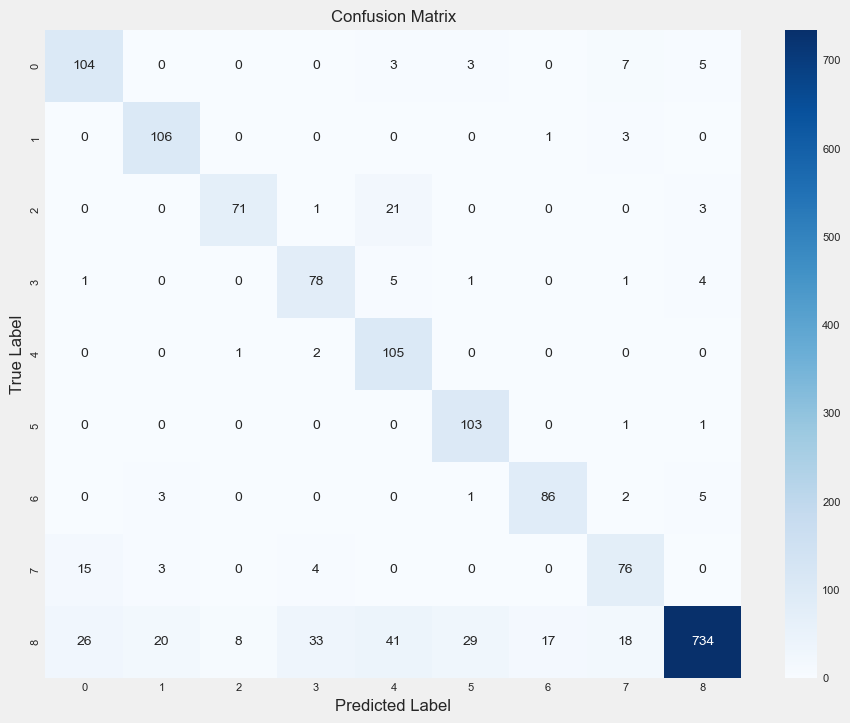

In [33]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

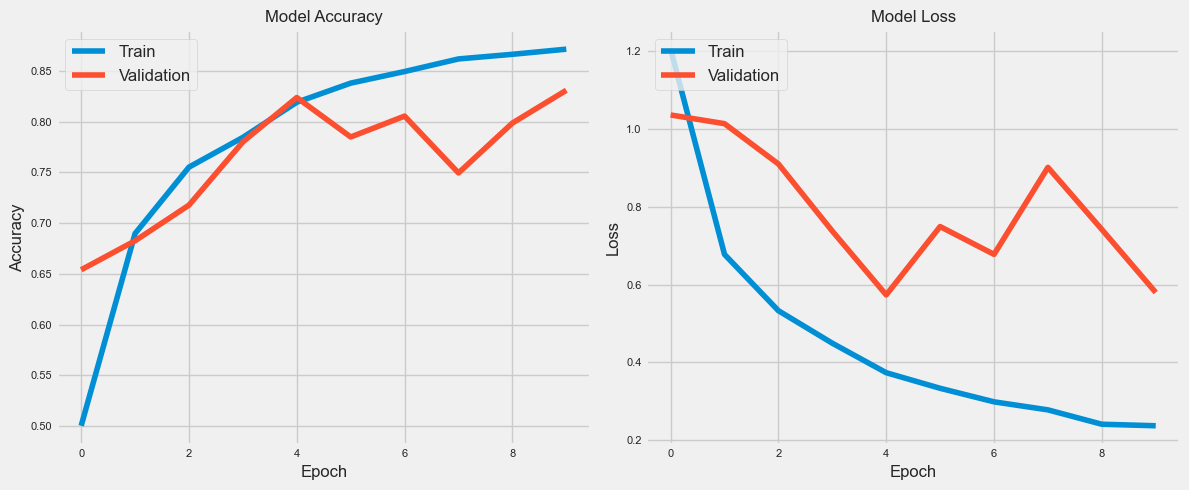

In [34]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

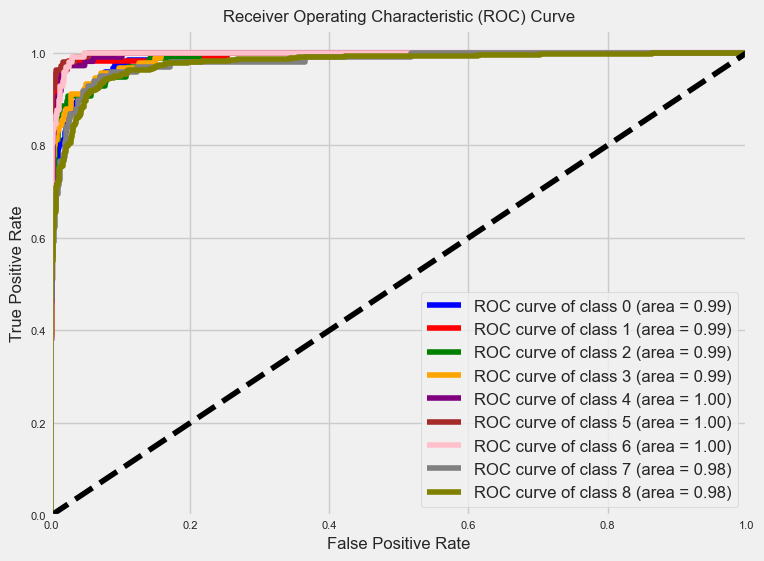

In [35]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']
for i, color in zip(range(n_classes), colors[:n_classes]):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


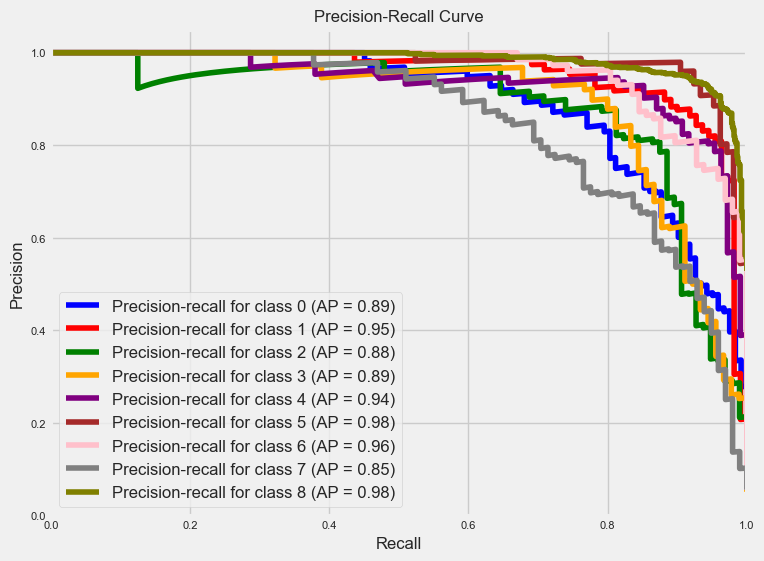

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors[:n_classes]):
    plt.plot(recall[i], precision[i], color=color,
             label='Precision-recall for class {0} (AP = {1:0.2f})'
             ''.format(class_labels[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()